# new RNN

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import seaborn as sns
# Load the NetCDF file
nc_file = 'data/derivatives/dataset_MOTOR_60_subjects_both.nc' # hrf convoluted + block, if we want to denoise data
np.random.seed(459345)
dataset = xr.open_dataset(nc_file)
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

TR=0.72

# Print dataset to inspect the contents
print(dataset)



<xarray.Dataset> Size: 813MB
Dimensions:  (subject: 60, voxel: 1989, time: 284)
Coordinates:
  * voxel    (voxel) int64 16kB 0 1 2 3 4 5 6 ... 1983 1984 1985 1986 1987 1988
  * time     (time) int64 2kB 0 1 2 3 4 5 6 7 ... 277 278 279 280 281 282 283
  * subject  (subject) <U9 2kB '118932_RL' '113619_LR' ... '148335_LR'
    task     <U5 20B ...
Data variables:
    X        (subject, voxel, time) float64 271MB ...
    Y        (subject, voxel, time) float64 271MB ...
    Y_conv   (subject, voxel, time) float64 271MB ...
Attributes:
    description:  Dataset for subject 118932, task MOTOR, acquisition RL


In [2]:
fs = 1 / TR  # Hz
cutoff = 0.1  # Low-pass filter cutoff frequency (Hz)
order = 4

def butter_lowpass():
    """
    Create a lowpass Butterworth filter.
    :param cutoff: Cutoff frequency of the filter (Hz)
    :param fs: Sampling frequency of the signal (Hz)
    :param order: Order of the filter
    :return: Filter coefficients (b, a)
    """
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    
    # Design the Butterworth filter
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    G0 = np.sum(b)/np.sum(a)
    # Normalize to ensure unit gain at zero frequency
    b = b / G0
    return b, a
    
def apply_lowpass_filter(tensor):
    """
    Apply a lowpass filter to a PyTorch tensor.
    :param tensor: PyTorch tensor to be filtered
    :param cutoff: Cutoff frequency (Hz)
    :param fs: Sampling frequency (Hz)
    :param order: Order of the filter
    :return: Filtered PyTorch tensor
    """
    # Convert the tensor to a NumPy array
    tensor_np = tensor.detach().cpu().numpy()

    print(f"Input tensor shape: {tensor_np.shape}")
    
    # Check the length of the input tensor
    if tensor_np.shape[-2] <= order:
        raise ValueError(f"Input tensor is too short for the specified filter order {order}. "
                         f"Consider increasing the length of your input signal or reducing the filter order.")
    
    # Design the filter
    b, a = butter_lowpass()
    
    # Apply the filter using filtfilt for zero-phase filtering
    filtered_np = filtfilt(b, a, tensor_np, axis=-2).copy()
    
    # Convert the filtered data back to a PyTorch tensor
    filtered_tensor = torch.tensor(filtered_np, dtype=tensor.dtype, device=tensor.device)
    
    return filtered_tensor


In [3]:

def augment_data(X_train, Y_train, Y_conv_train, shift_range=(-20, +20), amplitude_range=(0.5, 1.5), noise_std=0.1):
    """
    Augment the data by shifting and scaling the time series data.
    
    Parameters:
    - X_train, Y_train, Y_conv_train: Tensors for the BOLD signal and predicted signals (Y and Y_conv).
    - shift_range: Tuple defining the range for temporal shifts (in number of time steps).
    - amplitude_range: Tuple defining the range for amplitude scaling (scaling factor).
    
    Returns:
    - Augmented tensors for X, Y, and Y_conv.
    """
    print("Data augmentation")
    # Apply time shifts and amplitude scaling to the training set
    augmented_X = []
    augmented_Y = []
    augmented_Y_conv = []
    
    num_samples = X_train.shape[0]
    
    for i in range(num_samples):
        # 1. Apply random time shift
        shift = np.random.randint(shift_range[0], shift_range[1] + 1)  # Random shift between shift_range[0] and shift_range[1]
        shifted_X = torch.roll(X_train[i], shifts=shift, dims=0)
        shifted_Y = torch.roll(Y_train[i], shifts=shift, dims=0)
        shifted_Y_conv = torch.roll(Y_conv_train[i], shifts=shift, dims=0)

        # 2. Apply random amplitude scaling
        scale_factor = np.random.uniform(amplitude_range[0], amplitude_range[1])
        scaled_X = shifted_X * scale_factor
        scaled_Y = shifted_Y * scale_factor
        scaled_Y_conv = shifted_Y_conv * scale_factor

        # 3. Add Gaussian noise
        noise_X = torch.normal(mean=0, std=noise_std, size=scaled_X.shape).to(scaled_X.device)
        
        # Add the noise to the scaled data
        noisy_X = scaled_X + noise_X
        
        # Store augmented samples
        augmented_X.append(noisy_X)
        augmented_Y.append(scaled_Y)
        augmented_Y_conv.append(scaled_Y_conv)

    # Convert lists back to tensors
    augmented_X_tensor = torch.stack(augmented_X)
    augmented_Y_tensor = torch.stack(augmented_Y)
    augmented_Y_conv_tensor = torch.stack(augmented_Y_conv)

    return augmented_X_tensor, augmented_Y_tensor, augmented_Y_conv_tensor


def preprocess_subject_data(subject_data):
    """
    Preprocess the data for a given subject, including normalization, 
    handling missing values, and applying temporal shifts.

    Parameters:
    - subject_data: The data for a single subject.

    Returns:
    - X_tensor, Y_tensor, Y_conv_tensor: Preprocessed tensors for the BOLD signal and predicted signals.
    """
    print("Data preprocess")
    
    X_subject = subject_data['X']  # Shape: [voxels, time]
    Y_subject = subject_data['Y']  # Shape: [voxels, time]
    Y_conv_subject = subject_data['Y_conv']  # Shape: [voxels, time]

    # Access time series for all voxels
    X_vals = X_subject.values
    Y_vals = Y_subject.values
    Y_conv_vals = Y_conv_subject.values

    # Remove rows with NaNs in any voxel time series
    print("Remove rows with NaNs in any voxel time series")
    valid_mask = ~np.isnan(X_vals).any(axis=1)
    X_vals = X_vals[valid_mask]
    Y_vals = Y_vals[valid_mask]
    Y_conv_vals = Y_conv_vals[valid_mask]

    # Normalize BOLD signal (X)
    print("Normalize BOLD signal (X)")
    X_vals = (X_vals - np.mean(X_vals, axis=1, keepdims=True)) / np.std(X_vals, axis=1, keepdims=True)

    # Convert to PyTorch tensors
    print("Convert to PyTorch tensors")
    X_tensor = torch.tensor(X_vals, dtype=torch.float32)
    Y_tensor = torch.tensor(Y_vals, dtype=torch.float32)
    Y_conv_tensor = torch.tensor(Y_conv_vals, dtype=torch.float32)

    return X_tensor, Y_tensor, Y_conv_tensor


def split_and_shuffle_data(X_tensor, Y_tensor, Y_conv_tensor):
    """
    Shuffle and split the data into training, validation, and test sets.

    Parameters:
    - X_tensor, Y_tensor, Y_conv_tensor: Tensors for the BOLD signal and predicted signals.

    Returns:
    - X_train, X_val, X_test: Split training, validation, and test sets for BOLD signal.
    - Y_train, Y_val, Y_test: Split training, validation, and test sets for predicted signals.
    - Y_conv_train, Y_conv_val, Y_conv_test: Split training, validation, and test sets for predicted signals (Y_conv).
    """

    print("split_and_shuffle_data")
    num_samples = X_tensor.shape[0]
    indices = np.random.permutation(num_samples)
    X_tensor = X_tensor[indices]
    Y_tensor = Y_tensor[indices]
    Y_conv_tensor = Y_conv_tensor[indices]

    # Split data into train, validation, and test sets (60%, 20%, 20%)
    train_end = int(0.6 * num_samples)
    val_end = train_end + int(0.2 * num_samples)

    # Use torch.split for easier splitting
    X_train, X_val, X_test = torch.split(X_tensor, [train_end, val_end - train_end, num_samples - val_end])
    Y_train, Y_val, Y_test = torch.split(Y_tensor, [train_end, val_end - train_end, num_samples - val_end])
    Y_conv_train, Y_conv_val, Y_conv_test = torch.split(Y_conv_tensor, [train_end, val_end - train_end, num_samples - val_end])

    return X_train, X_val, X_test, Y_train, Y_val, Y_test, Y_conv_train, Y_conv_val, Y_conv_test


def concat_data(all_X_train, all_X_val, all_X_test, all_Y_train, all_Y_val, all_Y_test, all_Y_conv_train, all_Y_conv_val, all_Y_conv_test):
    """
    Concatenate the data from all subjects into one large dataset.

    Parameters:
    - all_X_train, all_X_val, all_X_test, all_Y_train, all_Y_val, all_Y_test, all_Y_conv_train, all_Y_conv_val, all_Y_conv_test: 
      Lists of tensors containing data for each subject.

    Returns:
    - Concatenated tensors for training, validation, and test sets.
    """
    X_train_def = torch.cat(all_X_train, dim=0).unsqueeze(-1)
    X_test_def = torch.cat(all_X_test, dim=0).unsqueeze(-1)
    X_val_def = torch.cat(all_X_val, dim=0).unsqueeze(-1)
    Y_train_def = torch.cat(all_Y_train, dim=0).unsqueeze(-1)
    Y_test_def = torch.cat(all_Y_test, dim=0).unsqueeze(-1)
    Y_val_def = torch.cat(all_Y_val, dim=0).unsqueeze(-1)
    Y_conv_train_def = torch.cat(all_Y_conv_train, dim=0).unsqueeze(-1)
    Y_conv_test_def = torch.cat(all_Y_conv_test, dim=0).unsqueeze(-1)
    Y_conv_val_def = torch.cat(all_Y_conv_val, dim=0).unsqueeze(-1)
    
    return X_train_def, X_test_def, X_val_def, Y_train_def, Y_test_def, Y_val_def, Y_conv_train_def, Y_conv_test_def, Y_conv_val_def


In [4]:
def get_data_tensors(subject_ids):
    """
    Function to load, preprocess, and split data for a given list of subjects.
    It normalizes the BOLD signal (X), applies temporal shifts (if any),
    and splits the data into training, validation, and test sets.

    Parameters:
    - subject_ids: List of subject IDs to process.

    Returns:
    - X_train, Y_train, Y_conv_train: Training data tensors for BOLD signal and predicted signals.
    - X_test, Y_test, Y_conv_test: Test data tensors for BOLD signal and predicted signals.
    - X_val, Y_val, Y_conv_val: Validation data tensors for BOLD signal and predicted signals.
    """

    all_X_train, all_X_val, all_X_test = [], [], []
    all_Y_train, all_Y_val, all_Y_test = [], [], []
    all_Y_conv_train, all_Y_conv_val, all_Y_conv_test = [], [], []

    # Process data for each subject
    for sub_id in subject_ids:
        #print(f"Processing subject: {sub_id}")
        subject_data = dataset.sel(subject=sub_id)
        
        # Extract time series for BOLD and predicted signals
        X_tensor, Y_tensor, Y_conv_tensor = preprocess_subject_data(subject_data)
        
        # Shuffle and split data into train, val, and test sets
        X_train, X_val, X_test, Y_train, Y_val, Y_test, Y_conv_train, Y_conv_val, Y_conv_test = split_and_shuffle_data(
            X_tensor, Y_tensor, Y_conv_tensor)

        # Apply data augmentation on the training set
        X_train_aug, Y_train_aug, Y_conv_train_aug = augment_data(X_train, Y_train, Y_conv_train)

        # Append the results for each subject
        # each for cycle, shift and amplitude for augmentation can change, in order to have variability
        all_X_train.append(X_train_aug)
        all_X_val.append(X_val)
        all_X_test.append(X_test)
        all_Y_train.append(Y_train_aug)
        all_Y_val.append(Y_val)
        all_Y_test.append(Y_test)
        all_Y_conv_train.append(Y_conv_train_aug)
        all_Y_conv_val.append(Y_conv_val)
        all_Y_conv_test.append(Y_conv_test)

    # Concatenate data for all subjects
    X_train_def, X_test_def, X_val_def, Y_train_def, Y_test_def, Y_val_def, Y_conv_train_def, Y_conv_test_def, Y_conv_val_def = concat_data(
        all_X_train, all_X_val, all_X_test, all_Y_train, all_Y_val, all_Y_test, all_Y_conv_train, all_Y_conv_val, all_Y_conv_test
    )

    print(f"Training data shape: {X_train_def.shape}, Test data shape: {X_test_def.shape}")
    print(f"Labels (Y) shapes: Train {Y_train_def.shape}, Test {Y_test_def.shape}")

    return X_train_def, Y_train_def, Y_conv_train_def, X_test_def, Y_test_def, Y_conv_test_def, X_val_def, Y_val_def, Y_conv_val_def


In [5]:
subjects_ids = dataset.subject.values
indices = np.arange(len(subjects_ids))
np.random.shuffle(indices)

all_subjects_shuffled = subjects_ids[indices]
subjects_ids_train = all_subjects_shuffled[0:50]
subjects_ids_test = all_subjects_shuffled[50:60]

X_train_def, Y_train_def, Y_conv_train_def, X_test_def, Y_test_def, Y_conv_test_def, X_val_def, Y_val_def, Y_conv_val_def = get_data_tensors(subjects_ids_train)


Data preprocess
Remove rows with NaNs in any voxel time series
Normalize BOLD signal (X)
Convert to PyTorch tensors
split_and_shuffle_data
Data augmentation
Data preprocess
Remove rows with NaNs in any voxel time series
Normalize BOLD signal (X)
Convert to PyTorch tensors
split_and_shuffle_data
Data augmentation
Data preprocess
Remove rows with NaNs in any voxel time series
Normalize BOLD signal (X)
Convert to PyTorch tensors
split_and_shuffle_data
Data augmentation
Data preprocess
Remove rows with NaNs in any voxel time series
Normalize BOLD signal (X)
Convert to PyTorch tensors
split_and_shuffle_data
Data augmentation
Data preprocess
Remove rows with NaNs in any voxel time series
Normalize BOLD signal (X)
Convert to PyTorch tensors
split_and_shuffle_data
Data augmentation
Data preprocess
Remove rows with NaNs in any voxel time series
Normalize BOLD signal (X)
Convert to PyTorch tensors
split_and_shuffle_data
Data augmentation
Data preprocess
Remove rows with NaNs in any voxel time se

X_train_def shape: torch.Size([57890, 284, 1]) 
Y_train_def shape: torch.Size([57890, 284, 1]), 
Y_conv_train_def shape: torch.Size([57890, 284, 1])


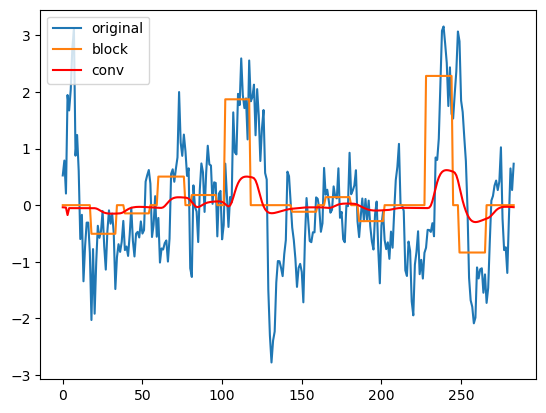

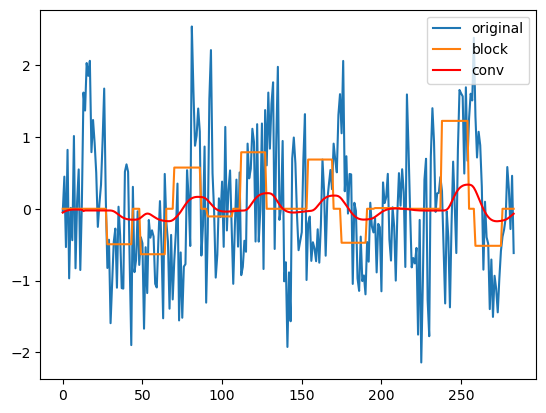

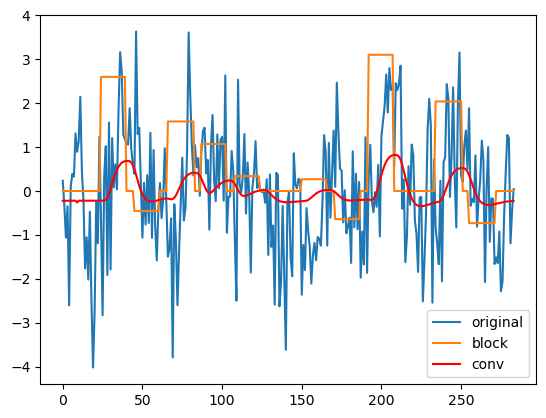

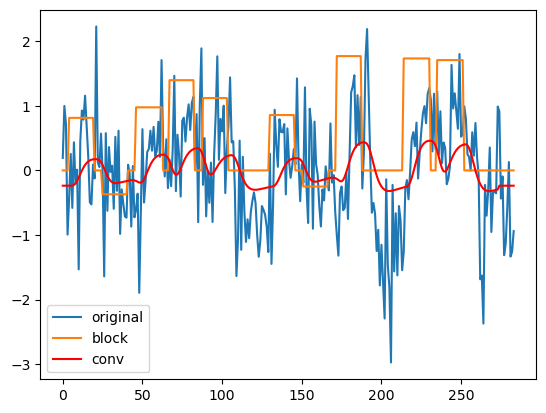

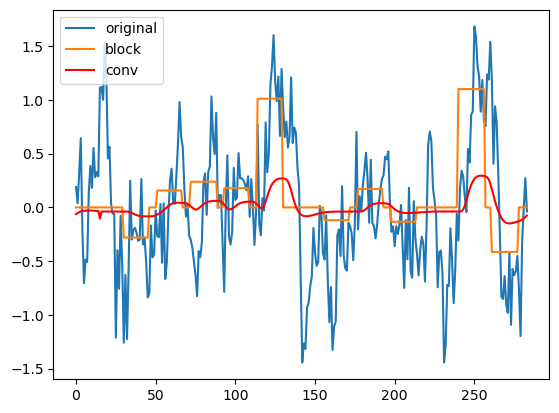

In [6]:
import matplotlib.pyplot as plt
print(f"X_train_def shape: {X_train_def.shape} \nY_train_def shape: {Y_train_def.shape}, \nY_conv_train_def shape: {Y_conv_train_def.shape}")
for i in range (5):
    
    x,y,z = X_train_def[i,:],Y_train_def[i,:],Y_conv_train_def[i,:]
    plt.plot(x,label="original")
    plt.plot(y,label='block')
    plt.plot(z,label='conv',color='red')
    plt.legend()
    plt.show()



X_train_def shape: torch.Size([57890, 284, 1]) 
Y_train_def shape: torch.Size([57890, 284, 1]), 
Y_conv_train_def shape: torch.Size([57890, 284, 1])


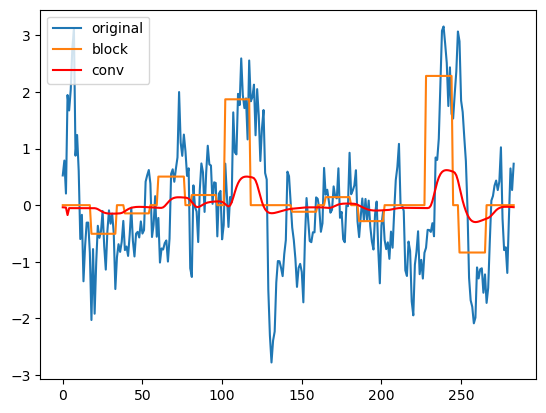

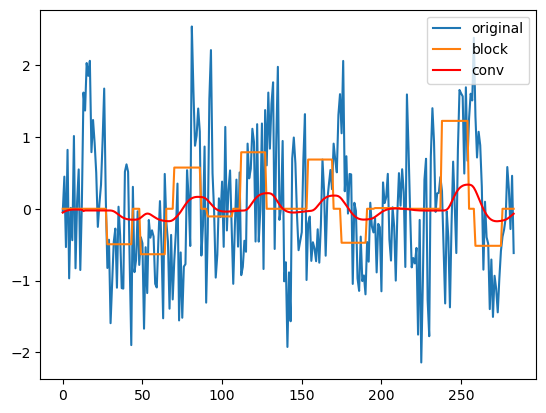

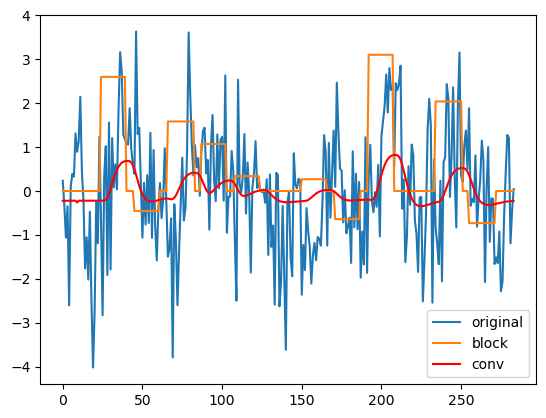

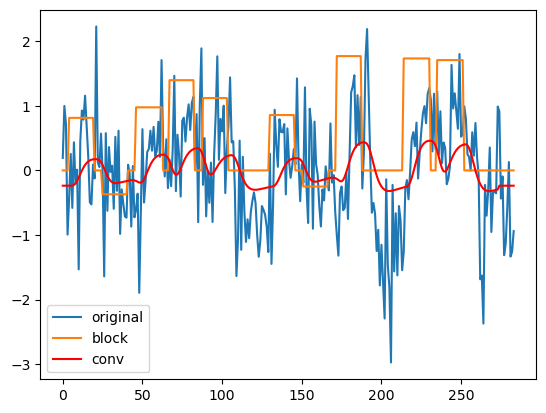

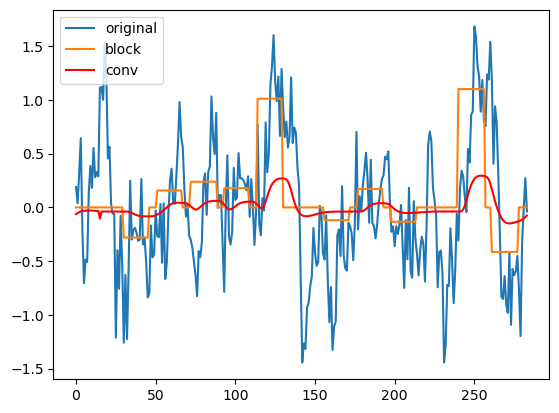

In [7]:
import matplotlib.pyplot as plt
print(f"X_train_def shape: {X_train_def.shape} \nY_train_def shape: {Y_train_def.shape}, \nY_conv_train_def shape: {Y_conv_train_def.shape}")

#X_train_def = apply_lowpass_filter(X_train_def)

for i in range (5):
    
    x,y,z = X_train_def[i,:],Y_train_def[i,:],Y_conv_train_def[i,:]
    plt.plot(x,label="original")
    plt.plot(y,label='block')
    plt.plot(z,label='conv',color='red')
    plt.legend()
    plt.show()

In [8]:
# ***************************************************
#                         MODELS
# ***************************************************

# LSTM CLASSIC

#class RNNModel(nn.Module):
#    def __init__(self, input_size, hidden_size, output_size):
#        super(RNNModel, self).__init__()
#        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True,num_layers=2) # Either GRU or LSTM
#        self.fc = nn.Linear(hidden_size, output_size)  # Maps hidden state to output
#
#    def forward(self, x):
#        # Pass through RNN
#        rnn_out, _ = self.rnn(x)  # rnn_out: (batch_size, seq_len, hidden_size)
#        
#        # Apply fully connected layer
#        output = self.fc(rnn_out)  # output: (batch_size, seq_len, output_size)
#        return output
#



# CNN + RNN Hybrid

#class RNNModel(nn.Module):
#    def __init__(self, input_size, hidden_size, output_size, dropout_prob=0.2):
#        super(RNNModel, self).__init__()
#         # 1D Convolutional Layer
#        self.conv1 = nn.Conv1d(input_size, 64, kernel_size=3, padding=1)
#        self.pool = nn.MaxPool1d(kernel_size=1)
#        
#        # RNN Layer (LSTM or GRU)
#        self.rnn = nn.LSTM(64, hidden_size, batch_first=True, num_layers=2, dropout=dropout_prob)
#        
#        # Fully connected layer
#        self.fc = nn.Linear(hidden_size, output_size)
#
#    def forward(self, x):
#        # Pass through CNN
#        x = x.permute(0, 2, 1)  # Change shape to (batch_size, channels, seq_len)
#        x = F.relu(self.conv1(x))
#        x = self.pool(x)
#        
#        # Reshape for RNN input
#        x = x.permute(0, 2, 1)  # (batch_size, seq_len, channels)
#        
#        # Pass through RNN
#        rnn_out, _ = self.rnn(x)
#        
#        # Pass the RNN output (all time steps) through the FC layer
#        output = self.fc(rnn_out)  # (batch_size, seq_len, output_size)
#        return output



# Multilayer RNN (Deep RNN)

#class RNNModel(nn.Module):
#    def __init__(self, input_size, hidden_size, output_size, num_layers=3, dropout_prob=0.2):
#        super(RNNModel, self).__init__()
#        
#        # Stack RNN layers
#        self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout_prob)
#        self.fc = nn.Linear(hidden_size, output_size)
#
#    def forward(self, x):
#        # Pass through stacked RNN layers
#        rnn_out, _ = self.rnn(x)  # rnn_out: (batch_size, seq_len, hidden_size)
#        
#        # Apply fully connected layer to the last time step's output
#        output = self.fc(rnn_out)  # Use only the last time step for prediction
#        return output
#


# LSTM with Attention Mechanism

#class RNNModel(nn.Module):
#    def __init__(self, input_size, hidden_size, output_size, dropout_prob=0.2):
#        super(RNNModel, self).__init__()
#        
#        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=2, dropout=dropout_prob)
#        self.attn = nn.Linear(hidden_size, hidden_size)
#        self.fc = nn.Linear(hidden_size, output_size)
#
#    def forward(self, x):
#        # Pass through LSTM
#        lstm_out, _ = self.lstm(x)  # lstm_out: (batch_size, seq_len, hidden_size)
#        
#        # Apply attention mechanism at each time step
#        attn_weights = F.softmax(self.attn(lstm_out), dim=2)  # Shape: (batch_size, seq_len, hidden_size)
#        weighted_out = attn_weights * lstm_out  # Apply attention: (batch_size, seq_len, hidden_size)
#        
#        # Pass weighted outputs through fully connected layer
#        output = self.fc(weighted_out)  # Shape: (batch_size, seq_len, output_size)
#        return output
#
#

# GRU Model

#class RNNModel(nn.Module):
#    def __init__(self, input_size, hidden_size, output_size, dropout_prob=0.2):
#        super(RNNModel, self).__init__()
#        
#        # GRU layer
#        self.gru = nn.GRU(input_size, hidden_size, batch_first=True, num_layers=2, dropout=dropout_prob)
#        # Fully connected layer
#        self.fc = nn.Linear(hidden_size, output_size)
#
#    def forward(self, x):
#        # Pass through GRU
#        gru_out, _ = self.gru(x)  # gru_out: (batch_size, seq_len, hidden_size)
#        
#        # Apply fully connected layer to the last time step's output
#        output = self.fc(gru_out)  # Use only the last time step for prediction
#        return output


# Bidirectional LSTM

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob=0.2):
        super(RNNModel, self).__init__()
        
        # Bidirectional LSTM layer
        self.bilstm = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=2, bidirectional=True, dropout=dropout_prob)
        # Fully connected layer
        self.fc = nn.Linear(hidden_size * 2, output_size)  # *2 because of bidirectional

    def forward(self, x):
        # Pass through BiLSTM
        lstm_out, _ = self.bilstm(x)  # lstm_out: (batch_size, seq_len, hidden_size * 2)
        
        # Use the output from the last time step
        output = self.fc(lstm_out)  # Last time step output
        return output


In [9]:

# Training and evaluation function
def train_model(model, criterion, train_loader, validation_loader, optimizer, num_epochs, device):
    train_losses = []  # To store average training loss for each epoch
    validation_losses = []
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_train_loss = 0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            #print(batch_x.shape) #(batch_size,timepoints,1)
            # Forward pass
            predictions = model(batch_x)
            loss = criterion(predictions, batch_y)
            total_train_loss += loss.item()

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_losses.append(avg_train_loss)  # Store train loss
        avg_train_loss = total_train_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}")

        # Evaluation phase
        model.eval()
        total_validation_loss = 0
        total_validation_mape = 0
        with torch.no_grad():
            for batch_x, batch_y in validation_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                predictions = model(batch_x)
                loss = criterion(predictions, batch_y)
                total_validation_loss += loss.item()
        avg_validation_loss = total_validation_loss / len(validation_loader)
        validation_losses.append(avg_validation_loss)  # Store test loss
        print(f"Epoch {epoch+1}/{num_epochs}, validation Loss: {avg_validation_loss:.4f}")
    # Plot the losses after training
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o')
    plt.plot(range(1, num_epochs + 1), validation_losses, label='validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.yscale('log') 
    plt.ylabel('Loss')
    plt.title('Train vs Test Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Training and evaluation function with early stopping
def train_model_with_early_stopping(
    model, criterion, train_loader, validation_loader, optimizer, num_epochs, device, patience=5
):
    train_losses = []  # To store average training loss for each epoch
    validation_losses = []   # To store average test loss for each epoch
    best_test_loss = float('inf')  # Initialize best test loss as infinity
    patience_counter = 0  # Counter to track epochs without improvement

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_train_loss = 0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            
            # Forward pass
            predictions = model(batch_x)

            # Check shapes
            if predictions.shape != batch_y.shape:
                raise ValueError(
                    f"Shape mismatch: Predictions {predictions.shape} vs Targets {batch_y.shape}. "
                    "Ensure model output matches target dimensions."
                )

            
            loss = criterion(predictions, batch_y)
            total_train_loss += loss.item()

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)  # Store train loss
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}")

        # Evaluation phase
        model.eval()
        total_validation_loss = 0
        with torch.no_grad():
            for batch_x, batch_y in validation_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                predictions = model(batch_x)
                loss = criterion(predictions, batch_y)
                total_validation_loss += loss.item()

        avg_validation_loss = total_validation_loss / len(validation_loader)
        validation_losses.append(avg_validation_loss)  # Store test loss
        print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {avg_validation_loss:.4f}")

        # Early stopping logic
        if avg_validation_loss < best_test_loss:
            best_test_loss = avg_validation_loss
            patience_counter = 0  # Reset patience counter
            best_model_state = model.state_dict()  # Save best model state
        else:
            patience_counter += 1
            print(f"No improvement for {patience_counter} epoch(s).")
        
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}.")
            break

        #NEW!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        # Step the scheduler with the validation loss
        scheduler.step(avg_validation_loss)  # Adjust the learning rate based on validation loss


    # Restore the best model weights
    #model.load_state_dict(best_model_state)

    # Plot the losses
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')
    plt.plot(range(1, len(validation_losses) + 1), validation_losses, label='validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.yscale('log') 
    plt.ylabel('Loss')
    plt.title('Train vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    return best_model_state



In [10]:
print(torch.cuda.is_available())
print(torch.version.cuda)
print(torch.backends.cudnn.enabled)
print(torch.cuda.device_count())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.cuda.set_device(2)  # Set device to cuda:2

curr_dev=torch.cuda.current_device()
print(curr_dev)

print(device)

print(torch.cuda.device(curr_dev))

print(torch.cuda.get_device_name(curr_dev))

True
11.8
True
4
2
cuda
NVIDIA A30


In [ ]:
import torch.nn.functional as F

# Hyperparameters
input_size = 1  # input is a single feature per voxel
hidden_size = 128
output_size = 1  # we predict one value per timeseries per voxel
num_epochs = 100
batch_size = 32
learning_rate = 0.0001
patience=10

X_train_def.to(device)
Y_train_def.to(device)
X_val_def.to(device)
Y_val_def.to(device)

# X_train_def = apply_lowpass_filter(X_train_def)
# X_val_def = apply_lowpass_filter(X_val_def)

train_dataset = TensorDataset(X_train_def, Y_train_def)
validation_dataset = TensorDataset(X_val_def, Y_val_def)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

# Model, Loss, Optimizer
model = RNNModel(input_size, hidden_size, output_size).to(device)
criterion = nn.L1Loss()  # MAE Loss

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)

# Train the model
#train_model(model, criterion, train_loader, test_loader, optimizer, num_epochs, device)
best_model_state = train_model_with_early_stopping(model, criterion, train_loader, validation_loader, optimizer, num_epochs, device,patience=patience)



Epoch 1/100, Train Loss: 0.4063
Epoch 1/100, Validation Loss: 0.3678
Epoch 2/100, Train Loss: 0.3559
Epoch 2/100, Validation Loss: 0.3362
Epoch 3/100, Train Loss: 0.3356
Epoch 3/100, Validation Loss: 0.3341
Epoch 4/100, Train Loss: 0.3229
Epoch 4/100, Validation Loss: 0.3136
Epoch 5/100, Train Loss: 0.3144
Epoch 5/100, Validation Loss: 0.2959
Epoch 6/100, Train Loss: 0.3071
Epoch 6/100, Validation Loss: 0.2923
Epoch 7/100, Train Loss: 0.3031


hints by chatgpt

1. Hidden Size and Layers: 
    
    Your model uses an LSTM with hidden_size = 128 and num_layers = 2. 
    This can be appropriate, but you could experiment with different values for the number of hidden units and layers.
    
    Increase Hidden Size: If the model is underfitting, try increasing the hidden_size (e.g., try 256 or 512).
    
    Number of Layers: You could experiment with more layers (e.g., num_layers=3), but be careful, as increasing the depth can also lead to overfitting or make training more difficult.




3. Overfitting Check and Regularization
    Your model seems to be doing well in terms of loss reduction, but there’s always the potential for overfitting, especially when the validation loss starts to plateau.

    Dropout: Adding dropout layers in your LSTM can help prevent overfitting. LSTM layers don't have inherent regularization, and dropout can make the model more generalizable.

    L2 Regularization: You can add weight decay to the Adam optimizer, which is a form of L2 regularization, to penalize large weights and prevent overfitting.


3. Gradient Clipping
    Gradient Exploding: LSTMs can suffer from exploding gradients, especially with long sequences or deep networks. To prevent this, you can apply gradient clipping to the optimizer to stabilize the training.



4. Loss Function
    Mean Squared Error Loss: You're using nn.MSELoss, which is standard for regression tasks. However, if your data contains outliers, MSE can be very sensitive. If that's the case, you could try using Huber Loss, which is more robust to outliers.


5. Increase Learning Rate or Use Scheduler:

   Try a slightly higher learning rate (e.g., 0.0005) or use a learning rate scheduler like ReduceLROnPlateau.

   scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)

In [ ]:
print(X_train_def.shape)

In [ ]:
model.load_state_dict(best_model_state)

In [ ]:
import matplotlib.pyplot as plt
# Assuming the model is already trained
model.eval()  # Set the model to evaluation mode

# Select one batch of test data from the loader
for X_sample, Y_sample in validation_loader:
    X_sample, Y_sample = X_sample.to(device), Y_sample.to(device)
    break  # Take the first batch

for i in range(10):
    X_sample_single = X_sample[i]
    Y_sample_single = Y_sample[i]

    # Get the prediction
    with torch.no_grad():
        Y_pred_single = model(X_sample_single.unsqueeze(0))  # Add batch dimension
        Y_pred_single = Y_pred_single.squeeze(0)  # Remove batch dimension

    # Convert to numpy for plotting
    Y_sample_single = Y_sample_single.cpu().numpy()
    Y_pred_single = Y_pred_single.cpu().numpy()
    X_sample_single= X_sample_single.cpu().numpy()
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(X_sample_single, label=f'Original (Sample {i+1})', linestyle='--')

    plt.plot(Y_sample_single, label=f'Correct (Sample {i+1})', linestyle='--')
    plt.plot(Y_pred_single, label=f'Predicted (Sample {i+1})', linestyle='-')
    plt.xlabel('Time Steps')
    plt.ylabel('Values')
    plt.title(f'Predicted vs Correct Time Series for Sample {i+1}')
    plt.legend()
    plt.show()

### New subjects

In [ ]:
print(subjects_ids_test)

In [ ]:
_,_,_,X_test_def_bis,Y_test_def_bis,Y_conv_test_def_bis,_,_,_ = get_data_tensors(subjects_ids_test)



In [ ]:
#X_test_def_bis = apply_lowpass_filter(X_test_def_bis)

test_dataset_bis = TensorDataset(X_test_def_bis, Y_test_def_bis)
test_loader_bis = DataLoader(test_dataset_bis, batch_size=batch_size, shuffle=True)


In [ ]:
model.eval()
total_test_loss = 0
loss_list = []
with torch.no_grad():
    for batch_x, batch_y in test_loader_bis:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        predictions = model(batch_x)
        loss = criterion(predictions, batch_y)
        #print(loss)
        total_test_loss += loss.item()
        loss_list.append(loss.item())

avg_test_loss = total_test_loss / len(test_loader_bis)
print(avg_test_loss)
plt.plot(loss_list)

In [ ]:
import matplotlib.pyplot as plt
# Assuming the model is already trained
model.eval()  # Set the model to evaluation mode

# Select one batch of test data from the loader
for X_sample, Y_sample in test_loader_bis:
    X_sample, Y_sample = X_sample.to(device), Y_sample.to(device)
    break  # Take the first batch

for i in range(10):
    X_sample_single = X_sample[i]
    Y_sample_single = Y_sample[i]

    # Get the prediction
    with torch.no_grad():
        Y_pred_single = model(X_sample_single.unsqueeze(0))  # Add batch dimension
        Y_pred_single = Y_pred_single.squeeze(0)  # Remove batch dimension

    # Convert to numpy for plotting
    Y_sample_single = Y_sample_single.cpu().numpy()
    Y_pred_single = Y_pred_single.cpu().numpy()
    X_sample_single = X_sample_single.cpu().numpy()
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(X_sample_single, label=f'Original (Sample {i+1})', linestyle='--')

    plt.plot(Y_sample_single, label=f'Correct (Sample {i+1})', linestyle='--')
    plt.plot(Y_pred_single, label=f'Predicted (Sample {i+1})', linestyle='-')
    plt.xlabel('Time Steps')
    plt.ylabel('Values')
    plt.title(f'Predicted vs Correct Time Series for Sample {i+1}')
    plt.legend()
    plt.show()